In [30]:
import numpy as np
import torch
import string
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pack_padded_sequence as pack
import math
import torch.utils.data as data
import json
import os
import pandas as pd
import random
import copy
import torch.utils.data.sampler as sampler
import torch.optim.lr_scheduler as lr_scheduler
import pickle
import pandas as pd
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Data import & preprocessing 

In [31]:
import pickle
with open('gamedata.pickle',"rb") as dt:
    data = pickle.load(dt)

In [6]:
data['102844212428895431'].columns

Index(['Time', 'Timestamp', 'blue_gold', 'blue_towers', 'blue_barons',
       'blue_totalKills', 'blue_dragons', 'red_gold', 'red_towers',
       'red_barons', 'red_totalKills', 'red_dragons'],
      dtype='object')

In [32]:
for game in data.keys():
    data[game]['Time'] = list(map(lambda x:int(x.split('-')[0])*3600+int(x.split('-')[1])*60+int(x.split('-')[2]),data[game]['Time']))

In [33]:
for game in data.keys():
    init = data[game]['Time'][0]
    data[game]['Time'] = list(map(lambda x:x-init,data[game]['Time']))

In [34]:
for i in data:
    index = 0
    time = 0
    datas = pd.DataFrame(columns = data[i].columns)
    while(time<data[i].iloc[-1]['Time']):
        temp = data[i].iloc[[index],:]
        if int(temp['Time']) == time:
            datas = pd.concat([datas,temp],ignore_index=True)
            index+=1
        else:
            temp['Time'] = time
            datas = pd.concat([datas,temp],ignore_index=True)
        time+=1
    data[i] = datas

/home/proj01/anaconda3/envs/t/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
for i in data:
    data[i] = data[i].drop(['Time','Timestamp'],axis='columns')

In [ ]:
sample = ['102844412722519367','102844212429550795','102844401151219358','102844401154430631','102844412717014335','102844401153971877','102844224148503678','102844412722847048','102844401152857762','102844412707380528','102844212431516886','102844283027925085','102844412716227901','102844412710001974','102844294670878922','102844294670551241','102844283023599703','102844412704496937','102844235751783874','102844401152071328','102844412709674293','102844401153447587','102844224148896895','102844235746868664','102979081290790284','102844283027531868','102844212431975640','102844401155937960','102844212429092040','102844341906649746','102844412706987311','102844412721339716','102844212430402768','102844341905011343','102844235753356742','102844235750997440','102844412709346612','102844412705217835','102844235752963525','102844412712164667','102844412705545516','102844341912220311','102844341907370644','102844235749424575','102844212429419722','102844294669568199','102844212431779031','102844294666422466','102844224146472059','102844212428895431','102844212429747404','102844235748703677','102844224146930812','102844212430730450','102844294674876621','102844341909598870','102844283020453971','102844294670026952','102844412723174729','102844341904683662','102844283025696858','102844235747261881','102844401154168486','102844235748310460','102844412711836986','102844412723567946','102844235749031358','102844294674286796','102844294666881219','102844412716686654','102844294671796427','102844224145685626','102844412717407552','102844235751390657','102844401156069033','102904869420860038','102910307641576395','102844341905404560','102844341906977427','102844212430075086','102844412711116088','102844401153578660','102844294667405508','102844412706659630','102844212431058132','102844341902586509','102844401152267937','102844212430927059','102844412708953395','102844212429944013','102844341912679064','102844235753749959','102844341908026005','102844283023206486','102844224147717245','102844412704890154','102844212430599377','102844412711443769','102844235747982779']

In [ ]:
temp=[]
for i in data:
    if i not in sample:
        temp.append(i)
for i in temp:
    data.pop(i)

In [37]:
'''
with open('./data/video_raw_feature_dataframe.pickle','wb') as f:
    pickle.dump(data,f)
'''

"\nwith open('./data/video_raw_feature_dataframe.pickle','wb') as f:\n    pickle.dump(data,f)\n"

# data loading 

In [7]:
with open('./data/video_raw_feature_dataframe.pickle','rb') as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/video_raw_feature_dataframe.pickle'

In [ ]:
'''
with open('./data/video_raw_feature.pickle','wb') as f:
    pickle.dump(data,f)
'''

In [8]:
with open('./data/video_raw_feature.pickle','rb') as f:
    raw = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/video_raw_feature.pickle'

In [ ]:
data['102844212428895431']

,blue_gold,blue_towers,blue_barons,blue_totalKills,blue_dragons,red_gold,red_towers,red_barons,red_totalKills,red_dragons
0,2500,0,0,0,0,2500,0,0,0,0
1,2500,0,0,0,0,2500,0,0,0,0
2,2500,0,0,0,0,2500,0,0,0,0
3,2500,0,0,0,0,2500,0,0,0,0
4,2500,0,0,0,0,2500,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2049,56071,4,0,5,4,62149,8,1,7,0
2050,56081,4,0,5,4,62159,8,1,7,0
2051,56091,4,0,5,4,62219,8,1,7,0
2052,56102,4,0,5,4,62230,8,1,7,0


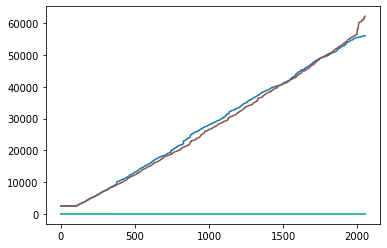

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(data['102844212428895431']))
plt.show()

In [11]:
with open('./data/video_statistic_features_one2.pickle','rb') as f:
    v2 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/video_statistic_features_one2.pickle'

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.array(v2['102844212428895431']))
plt.show()

NameError: name 'v2' is not defined

In [16]:
#변화율만 계산
for i in data:
    temp = pd.concat([data[i][data[i].index<1],data[i].drop(len(data[i])-1)],ignore_index=True)
    data[i] -= temp

In [17]:
data['102844212428895431']

,blue_gold,blue_towers,blue_barons,blue_totalKills,blue_dragons,red_gold,red_towers,red_barons,red_totalKills,red_dragons
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2049,10,0,0,0,0,31,0,0,0,0
2050,10,0,0,0,0,10,0,0,0,0
2051,10,0,0,0,0,60,0,0,0,0
2052,11,0,0,0,0,11,0,0,0,0


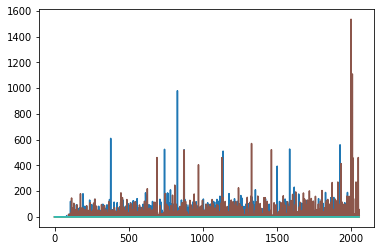

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.array(data['102844212428895431']))
plt.show()

In [22]:
#정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler()
data_scaled={}
for i in data:
    min_max_scaler.fit(data[i])
    output = min_max_scaler.transform(data[i])
    data_scaled[i] = pd.DataFrame(output,columns=data[i].columns)

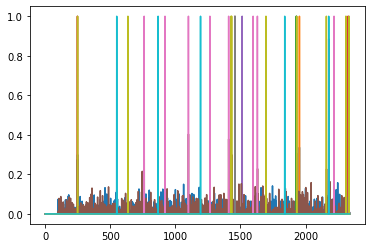

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.array(data_scaled['102844212430599377']))
plt.show()

In [24]:
data_sum={}
for i in data:
    data_sum[i] = data_scaled[i].values
    data_sum[i] = list(map(lambda x: np.sum(x),data_sum[i]))

In [15]:

with open('./data/video_raw_feature_no_smoothing.pickle','wb') as f:
    pickle.dump(data_sum,f)


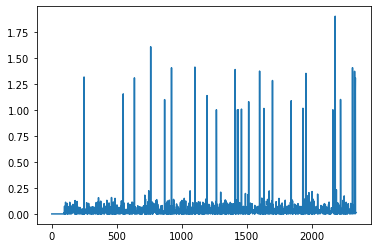

In [25]:
#sum
import matplotlib.pyplot as plt
plt.plot(np.array(data_sum['102844212430599377']))
plt.show()

In [26]:
data_sum_scaled={}
for key in data_sum.keys():
    m = max(data_sum[key])
    m = m/3
    data_sum_scaled[key] = list(map(lambda x : x[0] if x[1]>m else 0, enumerate(data_sum[key])))
    data_sum_scaled[key] = np.delete(data_sum_scaled[key], np.where(np.array(data_sum_scaled[key]) == 0), axis=0)

In [20]:
# 경험기반 스무딩 #이거 아님
for key in data_sum_scaled.keys():
    #print(tdelta[key])
    
    for index in data_sum_scaled[key]:
        before=[]
        #before 10
        v = 1/21
        temp=v
        for i in range(20):
            before.append(temp)
            temp+=v
        
        after=[]
        #after 7
        v = 1/15
        temp=v
        for i in range(14):
            after.insert(0,temp)
            temp+=v
        total=before
        total.append(1)
        total = total+after
        ti =0
        for i in range(max(0,-20+index),min(len(data_sum[key]),14+index)):
            if data_sum[key][i] < total[ti]:
                data_sum[key][i] = total[ti]
            ti+=1
        

In [31]:
#test 
import numpy as np
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    print(box)
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

smooth([1,1,1,1],2)

[0.5 0.5]


array([0.5, 1. , 1. , 1. ])

In [27]:
# savgol_filtering last selected!

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
for key in data_sum.keys():
    data_sum[key] = smooth(data_sum[key],7)

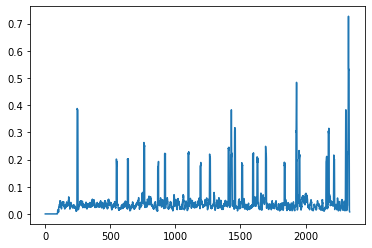

In [28]:
#sum
import matplotlib.pyplot as plt
plt.plot(np.array(data_sum['102844212430599377']))
plt.show()

In [29]:
with open('./data/video_raw_feature_sum_moving_average.pickle','wb') as f:
    pickle.dump(data_sum,f)

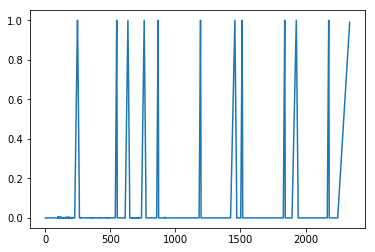

In [305]:
import matplotlib.pyplot as plt
plt.plot(np.array(v2['102844212430599377']))
plt.show()

In [255]:
for i in v2:
    print(i)

102844212430075086
102844212430271695
102844212429092040
102844212430402768
102844212430599377
102844212429747404
102844224148503678
102844212428895431
102844224148896895
102844212430730450
102844224146472059
102844212429419722
102844212429288649
102844212431779031
102844212431058132
102844212430927059
102844212429550795
102844212431320277
102904869420860038
102844224147717245
102844212431975640
102844224145685626
102844212429944013
102844224146930812
102844212431516886
102910307641576395
102844341902586509
102844341905404560
102844401153971877
102844401152071328
102844294670878922
102844294667405508
102844341907370644
102844341909598870
102844401155937960
102844401154430631
102844283027531868
102844283020453971
102844401152267937
102844401153578660
102844294669568199
102844294670551241
102844283027925085
102844283023599703
102844341906649746
102844341906256529
102844294667995333
102844294674286796
102844283025696858
102844283023206486
102844294674876621
102844294670026952
102844294666